# Telegram Mining (Notebook Autor-Klassifizierung)

**Master-Thesis: Social Media & Text Mining am Beispiel von Telegram**

Informatik Master

Maximilian Bundscherer

**Hinweis**: Die Abschnitte ``Arbeitungsumgebung initalisieren`` und ``Chats laden und aufbereiten`` werden im Notebook ``Telegram.iypnb`` bereits ausführlich beschrieben und werden daher hier übersprungen. 

## Arbeitumgsbebung initalisieren

Siehe Beschreibung im Notebook ``Telegram.ipynb``

In [1]:
# Import default libs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
import os
import sys
import demjson
import requests
import networkx as nx
import warnings
from pprint import pprint
from urllib.parse import urlparse
from collections import Counter
from pathlib import Path
from lxml.html import fromstring

In [2]:
# Hide DeprecationWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
!{sys.executable} -m pip install demoji

In [4]:
import nltk
import demoji

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [5]:
dictGloStopwatches = dict()

# Start timer (for reporting)
def gloStartStopwatch(key):
    print("[Stopwatch started >>" + str(key) + "<<]")
    dictGloStopwatches[key] = time.time()

# Stop timer (for reporting)
def gloStopStopwatch(key):
    endTime     = time.time()
    startTime   = dictGloStopwatches[key]
    print("[Stopwatch stopped >>" + str(key) + "<< (" + '{:5.3f}s'.format(endTime-startTime) + ")]")

In [6]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
demoji.download_codes()

... OK

 (Got response in 1.39 seconds)

Writing emoji data to /home/jovyan/.demoji/codes.json ...

... OK

In [8]:
# Show all columns (pandas hides columns by default)
pd.set_option('display.max_columns', None)

# Set plot style
plt.style.use('ggplot')

font = {'size'   : 13}

plt.rc('font', **font)

In [9]:
dir_var                 = "./work/notebooks/"
dir_var_output          = dir_var + "output/"
dir_var_pandas_cache    = dir_var + "cache/pandas/"

In [10]:
def gloReplaceGermanChars(inputText):

    inputText = inputText.replace("ö", "oe")
    inputText = inputText.replace("ü", "ue")
    inputText = inputText.replace("ä", "ae")

    inputText = inputText.replace("Ö", "Oe")
    inputText = inputText.replace("Ü", "Ue")
    inputText = inputText.replace("Ä", "Ae")

    inputText = inputText.replace("ß", "ss")
    
    return inputText

In [11]:
# Rm unsafe chars
def gloConvertToSafeString(text):
    text = demoji.replace(text, "")
    text = gloReplaceGermanChars(text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

# Generate unique chat name
def gloConvertToSafeChatName(chatName):
    chatName = gloConvertToSafeString(chatName)
    return chatName[:30]

In [12]:
def gloGetStopWordsList(filterList):

    stopwWorldsList = []

    deWordsList = nltk.corpus.stopwords.words('german')

    enWordsList = nltk.corpus.stopwords.words('english')

    aStopwords = []
    with open(dir_var + "additionalStopwords.txt") as file:
        for line in file: 
            line = line.strip()
            if(line != ""):
                aStopwords.append(line)

    for s in filterList:
        s = gloReplaceGermanChars(s)
        stopwWorldsList.append(s)

    for s in deWordsList:
        s = gloReplaceGermanChars(s)
        stopwWorldsList.append(s)

    for s in enWordsList:
        stopwWorldsList.append(s)

    for s in aStopwords:
        s = gloReplaceGermanChars(s)
        stopwWorldsList.append(s)

    return stopwWorldsList

## Chats laden und aufbereiten

Siehe Beschreibung im Notebook ``Telegram.ipynb``

## Klassifizierung nach Autoren

Siehe Beschreibung in ``Thesis.pdf``

### Daten laden

In [13]:
C_USE_CACHE_FILE = "final-run-24-03.pkl"

#### Von Cache Laden

In [14]:
gloStartStopwatch("Cache einlesen")
dfAllDataMessages = pd.read_pickle(dir_var_pandas_cache + C_USE_CACHE_FILE)
gloStopStopwatch("Cache einlesen")

[Stopwatch started >>Cache einlesen<<]

[Stopwatch stopped >>Cache einlesen<< (36.597s)]

#### Filtern und anzeigen

In [15]:
dfAllDataMessages= dfAllDataMessages[dfAllDataMessages['ftFilePath'].isin(
    [
        "DS-05-01-2021/ChatExport_2021-01-05-hildmann",
        "DS-05-01-2021/ChatExport_2021-01-05-janich",
        "DS-05-01-2021/ChatExport_2021-01-05-xavier",
        "DS-05-01-2021/ChatExport_2021-01-05-evaherman"
    ]
)]

dfAllDataMessages = dfAllDataMessages[dfAllDataMessages.ftQrIsValidText == True]
dfAllDataMessages = dfAllDataMessages[dfAllDataMessages.ftTdCleanText != ""]
dfAllDataMessages = dfAllDataMessages[dfAllDataMessages.ftTdTextLength > 5]

dfAllDataMessages["from"] = dfAllDataMessages["from"].apply(gloConvertToSafeChatName)

In [16]:
dfAllDataMessages.head(3)

,id,type,date,actor,actor_id,action,title,text,from,from_id,file,media_type,mime_type,duration_seconds,edited,thumbnail,width,height,photo,forwarded_from,poll.question,poll.closed,poll.total_voters,poll.answers,sticker_emoji,message_id,reply_to_message_id,location_information.latitude,location_information.longitude,live_location_period_seconds,via_bot,performer,ftFilePath,ftChatType,ftIsJsonFormatted,tmpExtractedTD,ftTdText,ftTdUrls,ftTdHashtags,ftTdBolds,ftTdItalics,ftTdUnderlines,ftTdEmails,ftTdCleanText,ftTdEmojis,ftTdEmojisDesc,ftTdSafeText,ftTdSafeLowerText,ftTdTextLength,ftQrIsValidText,ftQrIsEdited,ftQrIsForwarded,ftQrCoPhotos,ftQrCoFiles,ftQrCoUrls,ftQrCoHashtags,ftQrCoBolds,ftQrCoItalics,ftQrCoUnderlines,ftQrCoEmails,ftQrCoEmojis,ftTrNerRoberta,ftTrNerBert,ftTrSenBert,ftSenTb,author,saved_from,members,game_title,game_description,game_link,game_message_id,score,inviter,contact_vcard,contact_information.first_name,contact_information.last_name,contact_information.phone_number,place_name,address
1,2,message,2020-04-28T08:22:29,NaN,NaN,NaN,NaN,Dann schreiben wir mal Geschichte!,ATTILA HILDMANN,1.003416e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DS-05-01-2021/ChatExport_2021-01-05-hildmann,public_channel,False,"(Dann schreiben wir mal Geschichte!, [], [], [...",Dann schreiben wir mal Geschichte!,[],[],[],[],[],[],Dann schreiben wir mal Geschichte!,[],[],Dann schreiben wir mal Geschichte,dann schreiben wir mal geschichte,34,True,False,False,False,False,False,False,False,False,False,False,False,"{'per': [], 'misc': [], 'org': [], 'loc': []}","{'per': [], 'misc': [], 'org': [], 'loc': []}",5.0,"{'polarity': 0.0, 'subjectivity': 0.0}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,message,2020-04-28T08:43:27,NaN,NaN,NaN,NaN,Das Video sollte jeder von euch schauen und ve...,ATTILA HILDMANN,1.003416e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DS-05-01-2021/ChatExport_2021-01-05-hildmann,public_channel,False,(Das Video sollte jeder von euch schauen und v...,Das Video sollte jeder von euch schauen und ve...,[],[],[],[],[],[],Das Video sollte jeder von euch schauen und ve...,[],[],Das Video sollte jeder von euch schauen und ve...,das video sollte jeder von euch schauen und ve...,100,True,False,False,False,False,False,False,False,False,False,False,False,"{'per': [], 'misc': [], 'org': [], 'loc': ['▁C...","{'per': [], 'misc': [], 'org': [], 'loc': []}",5.0,"{'polarity': 0.0, 'subjectivity': 0.0}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,message,2020-04-28T08:43:31,NaN,NaN,NaN,NaN,"[SCHAUT ES EUCH AN! 🆘 , {'type': 'link', 'text...",ATTILA HILDMANN,1.003416e+10,NaN,NaN,NaN,NaN,2020-04-28T08:52:04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DS-05-01-2021/ChatExport_2021-01-05-hildmann,public_channel,True,"(SCHAUT ES EUCH AN! 🆘 , [https://www.instagram...",SCHAUT ES EUCH AN! 🆘,[https://www.instagram.com/tv/B_f_sYFqfvw/?igs...,[],[],[],[],[],SCHAUT ES EUCH AN!,[🆘],[SOS button],SCHAUT ES EUCH AN,schaut es euch an,21,True,True,False,False,False,True,False,False,False,False,False,True,"{'per': [], 'misc': [], 'org': [], 'loc': []}","{'per': [], 'misc': [], 'org': [], 'loc': []}",5.0,"{'polarity': 0.0, 'subjectivity': 0.0}",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Daten aufbereiten

#### Classifier Features

In [17]:
targetDf = dfAllDataMessages

targetDf['clFrom']    = targetDf['from']
targetDf['clFromId']  = targetDf['from'].factorize()[0]
targetDf['clText']    = targetDf['ftTdCleanText']

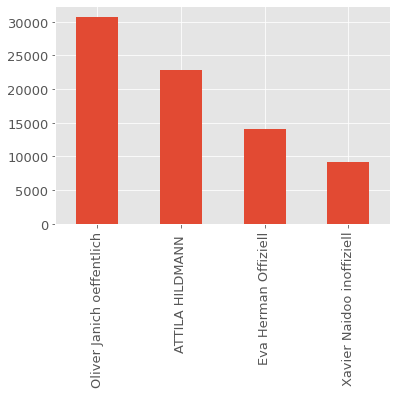

In [18]:
_ = targetDf['clFrom'].value_counts().plot.bar()

In [19]:
targetDf['clText'][:5]

1                   Dann schreiben wir mal Geschichte!
4    Das Video sollte jeder von euch schauen und ve...
5                                SCHAUT ES EUCH AN!   
6    Billyboy spricht schon heute, APRIL 2020, von ...
7    Beachtet sein Grinsen am Anfang und Ende des V...
Name: clText, dtype: object

In [20]:
targetDf['clFromId'].value_counts()

1    30740
0    22885
2    14067
3     9103
Name: clFromId, dtype: int64

In [21]:
def getSamples(df, k=9103):
    if len(df) < k:
        return df
    return df.sample(k)

targetDf = targetDf.groupby('clFromId').apply(getSamples).reset_index(drop=True)

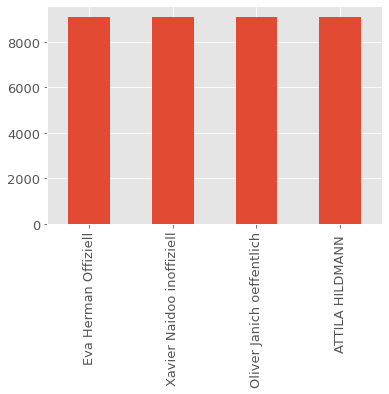

In [22]:
_ = targetDf['clFrom'].value_counts().plot.bar()

#### Dict From Id

In [23]:
dfFromId            = targetDf[['clFrom', 'clFromId']].drop_duplicates().sort_values('clFromId')

dictFrom_to_id      = dict(dfFromId.values)
dictId_to_from      = dict(dfFromId[['clFromId', 'clFrom']].values)

In [24]:
dictId_to_from

{0: 'ATTILA HILDMANN ',
 1: 'Oliver Janich oeffentlich',
 2: 'Eva Herman Offiziell',
 3: 'Xavier Naidoo inoffiziell'}

#### Test Train Split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(targetDf['clText'], targetDf['clFrom'], random_state = 42, test_size=0.20, stratify=targetDf['clFrom'])

print("Train size:\t" + str(len(X_train.index)))
print("Test size:\t" + str(len(X_test.index)))

Train size:	29129

Test size:	7283

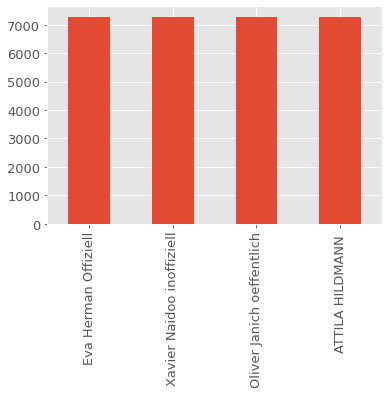

In [26]:
_ = y_train.value_counts().plot.bar()

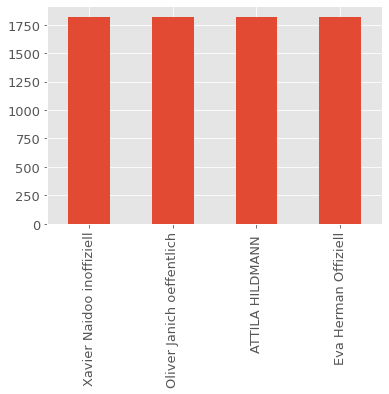

In [27]:
_ = y_test.value_counts().plot.bar()

#### Test CountVectorizer

In [28]:
test = CountVectorizer()

In [29]:
d1 = test.fit_transform(["Word1 Word2 Word3 Word4 Word1 Word2 Word1"])
d1.toarray()

array([[3, 2, 1, 1]])

In [30]:
test.get_feature_names()

['word1', 'word2', 'word3', 'word4']

In [31]:
d2 = test.transform(["Word1 Wrong Word3 Wrong Word1"])
d2.toarray()

array([[2, 0, 1, 0]])

In [32]:
test.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

#### Test TfidfTransformer

In [33]:
test = TfidfTransformer()

In [34]:
test.fit_transform(d1).toarray()

array([[0.77459667, 0.51639778, 0.25819889, 0.25819889]])

In [35]:
test.transform(d2).toarray()

array([[0.89442719, 0.        , 0.4472136 , 0.        ]])

### Tranieren und Evaluieren

In [36]:
gloStartStopwatch("Transform messages")

count_vect          = CountVectorizer()
tfidf_transformer   = TfidfTransformer()

# Transform and fit train
X_train_counts      = count_vect.fit_transform(X_train)
X_train_tfidf       = tfidf_transformer.fit_transform(X_train_counts)

# Transform test
X_test_counts       = count_vect.transform(X_test)
X_test_tfidf        = tfidf_transformer.transform(X_test_counts)

gloStopStopwatch("Transform messages")

[Stopwatch started >>Transform messages<<]

[Stopwatch stopped >>Transform messages<< (2.037s)]

In [37]:
def trainAndEvalModel(model, outputFilename):

    gloStartStopwatch("- Train now model " + str(model))
    model.fit(X_train_tfidf, y_train)
    gloStopStopwatch("- Train now model " + str(model))

    searchStrings = ["Folge Attila Hildmann", "Liebe Eva", "Premium Kanal", "OneLove"]

    for sS in searchStrings:

        sS = str(sS)
        print()
        print("Who has written '" + sS + "'?")
        t = tfidf_transformer.transform(count_vect.transform([sS]))
        r = model.predict(t)
        print(str(r))

    y_pred_train        = model.predict(X_train_tfidf)
    y_pred_test         = model.predict(X_test_tfidf)

    print()
    print("Train Score:\t"  + str(accuracy_score(y_true=y_train, y_pred=y_pred_train)))
    print("Test Score:\t"   + str(accuracy_score(y_true=y_test, y_pred=y_pred_test)))

    print()
    print("Confusion Matrix on test:")   
    conf_mat = confusion_matrix(y_true = y_test, y_pred = y_pred_test)
    fig, ax  = plt.subplots(figsize=(9,9))

    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=dfFromId.clFrom.values, yticklabels=dfFromId.clFrom.values)
                
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    if(outputFilename != ""):
        plt.savefig(dir_var_output + outputFilename)

    plt.show()

#### LinearSVC

[Stopwatch started >>- Train now model LinearSVC()<<]

[Stopwatch stopped >>- Train now model LinearSVC()<< (1.017s)]

Who has written 'Folge Attila Hildmann'?

['ATTILA HILDMANN ']

Who has written 'Liebe Eva'?

['Eva Herman Offiziell']

Who has written 'Premium Kanal'?

['Oliver Janich oeffentlich']

Who has written 'OneLove'?

['Xavier Naidoo inoffiziell']

Train Score:	0.9570874386350372

Test Score:	0.6888644789235205

Confusion Matrix on test:

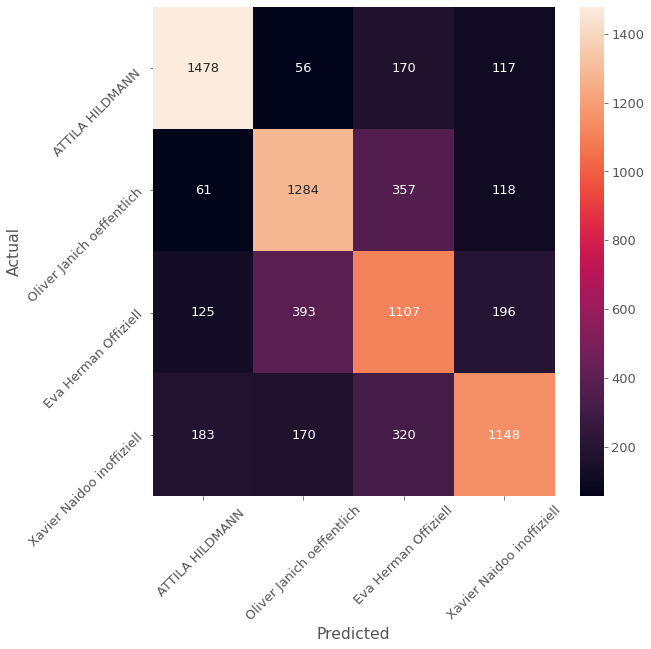

In [38]:
trainAndEvalModel(LinearSVC(), "class-linearsvc.svg")

#### MultinomialNB

[Stopwatch started >>- Train now model MultinomialNB()<<]

[Stopwatch stopped >>- Train now model MultinomialNB()<< (0.139s)]

Who has written 'Folge Attila Hildmann'?

['ATTILA HILDMANN ']

Who has written 'Liebe Eva'?

['Eva Herman Offiziell']

Who has written 'Premium Kanal'?

['Oliver Janich oeffentlich']

Who has written 'OneLove'?

['Xavier Naidoo inoffiziell']

Train Score:	0.791444951766281

Test Score:	0.6583825346697789

Confusion Matrix on test:

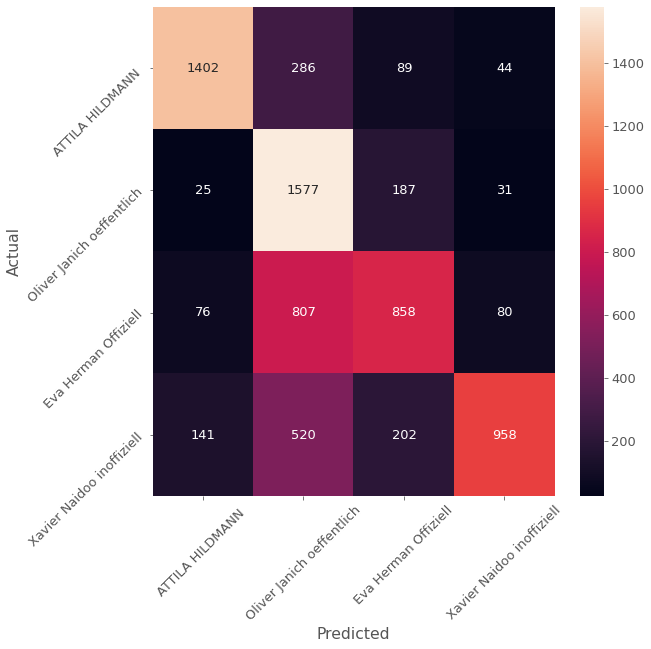

In [39]:
trainAndEvalModel(MultinomialNB(), "class-multinomialnb.svg")

#### LogisticRegression

[Stopwatch started >>- Train now model LogisticRegression()<<]

/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[Stopwatch stopped >>- Train now model LogisticRegression()<< (7.351s)]

Who has written 'Folge Attila Hildmann'?

['ATTILA HILDMANN ']

Who has written 'Liebe Eva'?

['Eva Herman Offiziell']

Who has written 'Premium Kanal'?

['Oliver Janich oeffentlich']

Who has written 'OneLove'?

['Xavier Naidoo inoffiziell']

Train Score:	0.854818222390058

Test Score:	0.6969655361801456

Confusion Matrix on test:

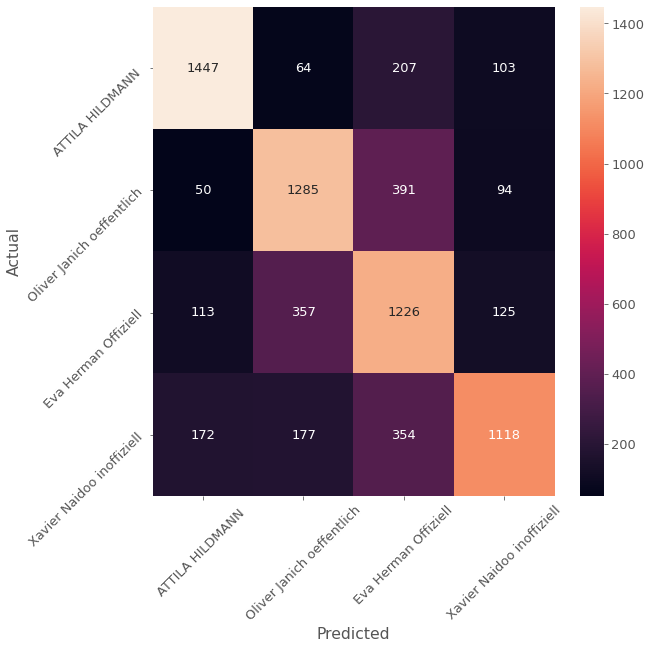

In [40]:
trainAndEvalModel(LogisticRegression(), "class-logisticregression.svg")

#### MLPClassifier

[Stopwatch started >>- Train now model MLPClassifier()<<]

[Stopwatch stopped >>- Train now model MLPClassifier()<< (4865.285s)]

Who has written 'Folge Attila Hildmann'?

['Xavier Naidoo inoffiziell']

Who has written 'Liebe Eva'?

['Eva Herman Offiziell']

Who has written 'Premium Kanal'?

['Oliver Janich oeffentlich']

Who has written 'OneLove'?

['Xavier Naidoo inoffiziell']

Train Score:	0.976895876961104

Test Score:	0.646848826033228

Confusion Matrix on test:

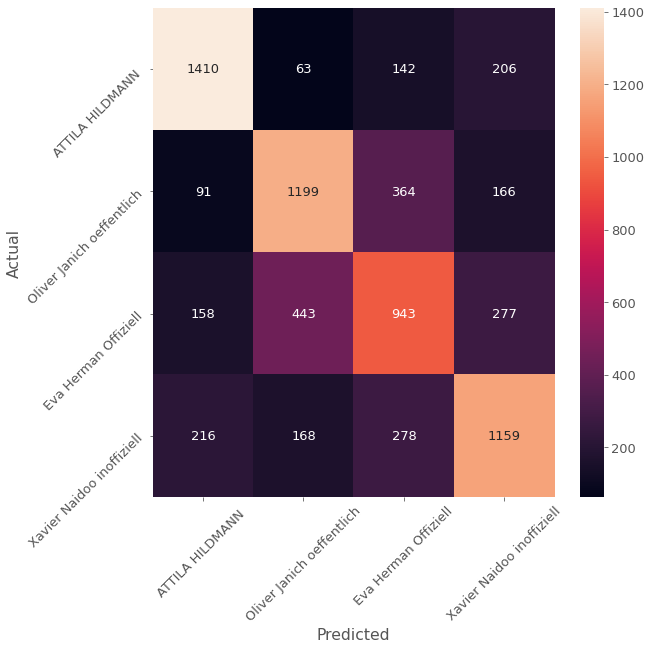

In [41]:
trainAndEvalModel(MLPClassifier(), "class-mlp.svg")

#### DecisionTreeClassifier

[Stopwatch started >>- Train now model DecisionTreeClassifier()<<]

[Stopwatch stopped >>- Train now model DecisionTreeClassifier()<< (28.759s)]

Who has written 'Folge Attila Hildmann'?

['Xavier Naidoo inoffiziell']

Who has written 'Liebe Eva'?

['Eva Herman Offiziell']

Who has written 'Premium Kanal'?

['Xavier Naidoo inoffiziell']

Who has written 'OneLove'?

['ATTILA HILDMANN ']

Train Score:	0.9774108276974836

Test Score:	0.5503226692297131

Confusion Matrix on test:

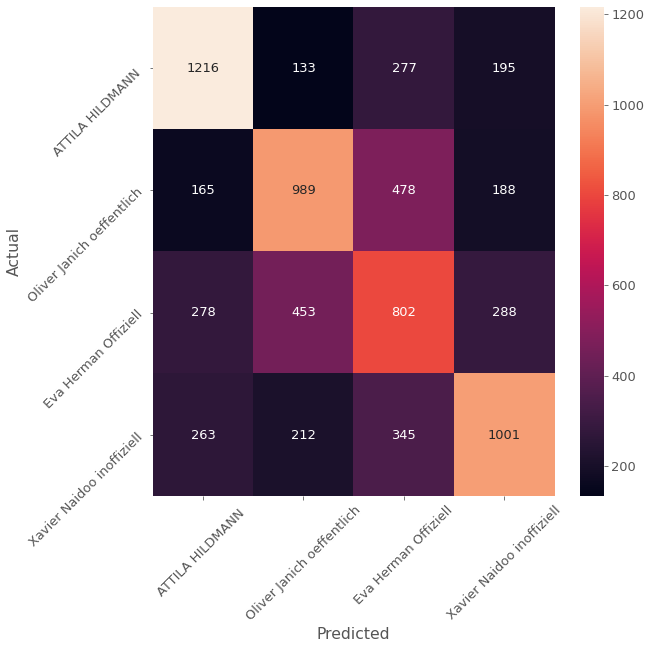

In [42]:
trainAndEvalModel(DecisionTreeClassifier(), "class-decisiontree.svg")

#### RandomForestClassifier

[Stopwatch started >>- Train now model RandomForestClassifier()<<]

[Stopwatch stopped >>- Train now model RandomForestClassifier()<< (369.937s)]

Who has written 'Folge Attila Hildmann'?

['ATTILA HILDMANN ']

Who has written 'Liebe Eva'?

['Eva Herman Offiziell']

Who has written 'Premium Kanal'?

['ATTILA HILDMANN ']

Who has written 'OneLove'?

['Xavier Naidoo inoffiziell']

Train Score:	0.9774108276974836

Test Score:	0.6338047507895098

Confusion Matrix on test:

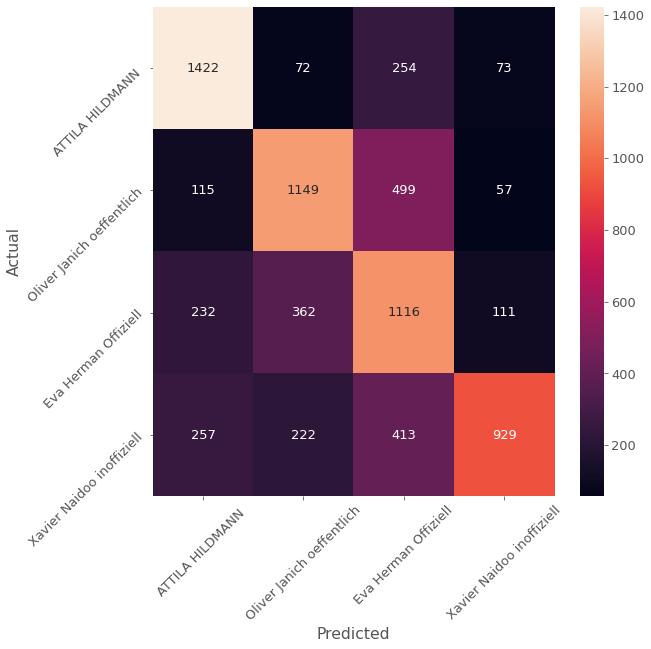

In [43]:
trainAndEvalModel(RandomForestClassifier(), "class-randomforest.svg")

#### DummyClassifier

[Stopwatch started >>- Train now model DummyClassifier(strategy='uniform')<<]

[Stopwatch stopped >>- Train now model DummyClassifier(strategy='uniform')<< (0.026s)]

Who has written 'Folge Attila Hildmann'?

['ATTILA HILDMANN ']

Who has written 'Liebe Eva'?

['ATTILA HILDMANN ']

Who has written 'Premium Kanal'?

['Xavier Naidoo inoffiziell']

Who has written 'OneLove'?

['Oliver Janich oeffentlich']

Train Score:	0.2516735898932336

Test Score:	0.2516819991761637

Confusion Matrix on test:

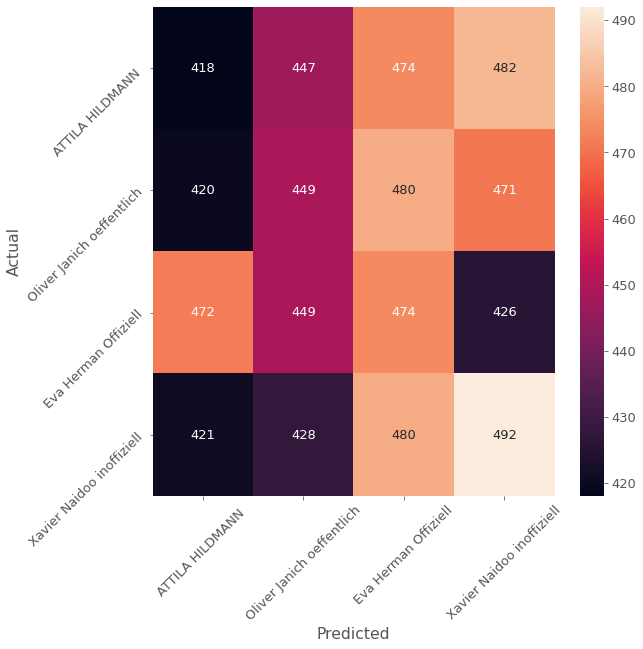

In [44]:
trainAndEvalModel(DummyClassifier(strategy="uniform"), "class-dummy.svg")

## Mehr lesen / Inspirationen

- https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f
- https://towardsai.net/p/data-mining/text-mining-in-python-steps-and-examples-78b3f8fd913b
- https://towardsdatascience.com/text-mining-for-dummies-text-classification-with-python-98e47c3a9deb
- https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/
- https://realpython.com/python-keras-text-classification/
- https://www.tidytextmining.com/ngrams.html
- http://seaborn.pydata.org/tutorial/categorical.html?highlight=bar%20plot
- https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166
- https://www.kirenz.com/post/2019-08-13-network_analysis/
- https://tgstat.com
- https://huggingface.co/bert-base-german-cased
- https://github.com/sekhansen/text-mining-tutorial/tree/master
- https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
- https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
- https://github.com/sekhansen/text-mining-tutorial/blob/master/tutorial_notebook.ipynb
- https://textmining.wp.hs-hannover.de/Preprocessing.html
- https://likegeeks.com/nlp-tutorial-using-python-nltk/
- https://www.datacamp.com/community/tutorials/text-analytics-beginners-nltk
- https://data-flair.training/blogs/nltk-python-tutorial/
- https://github.com/expectocode/telegram-analysis
- https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame